In [1]:
%load_ext autoreload
%autoreload 2

import logging

import helpers.dbg as dbg
import helpers.printing as prnt

prnt.config_notebook()

#dbg.init_logger(verbosity=logging.DEBUG)
dbg.init_logger(verbosity=logging.INFO)
# dbg.test_logger()
_LOG = logging.getLogger(__name__)

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-6728fe92-8743-4b7e-a75e-1e8c61ec2f69.json'


In [2]:
_LOG.debug = _LOG.info

# Generate random data

In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

#date_range = pd.date_range("09:30", "15:00", freq="1T")
date_range = pd.date_range("09:30", "10:00", freq="1T")

diff = np.random.normal(0, 1, size=len(date_range))
diff = diff.cumsum()
price = 100.0 + diff
df = pd.DataFrame(price, index=date_range, columns=["price"])

# ask, bid
df["ask"] = price + np.abs(np.random.normal(0, 1, size=len(date_range)))
df["bid"] = price - np.abs(np.random.normal(0, 1, size=len(date_range)))
display(df.head(5))

,price,ask,bid
2021-09-08 09:30:00,100.496714,102.348992,99.390379
2021-09-08 09:31:00,100.358450,100.371947,99.162243
2021-09-08 09:32:00,101.006138,102.063849,100.193613
2021-09-08 09:33:00,102.529168,103.351713,101.172928
2021-09-08 09:34:00,102.295015,103.515859,102.223005


## Case 1: instantaneous, no costs

In [4]:
# Sample on 5 minute bars labeling and close on the right

df_5mins = df.resample("5T", closed="right", label="right").last()
    
df_5mins["ret_0"] = df_5mins["price"].pct_change()

np.random.seed(42)
df_5mins["preds"] = (np.random.random(df_5mins.shape[0]) >= 0.5) * 2.0 - 1.0
display(df_5mins)

,price,ask,bid,ret_0,preds
2021-09-08 09:30:00,100.496714,102.348992,99.390379,NaN,-1.0
2021-09-08 09:35:00,102.060878,102.269742,101.057345,0.015564,-1.0
2021-09-08 09:40:00,104.017193,104.188562,103.981367,0.019168,1.0
2021-09-08 09:45:00,99.592940,100.053579,99.293933,-0.042534,1.0
2021-09-08 09:50:00,98.039678,98.424760,96.561783,-0.015596,-1.0
2021-09-08 09:55:00,96.023221,96.862439,95.694470,-0.020568,1.0
2021-09-08 10:00:00,93.753887,93.939545,93.051833,-0.023633,-1.0


<AxesSubplot:>

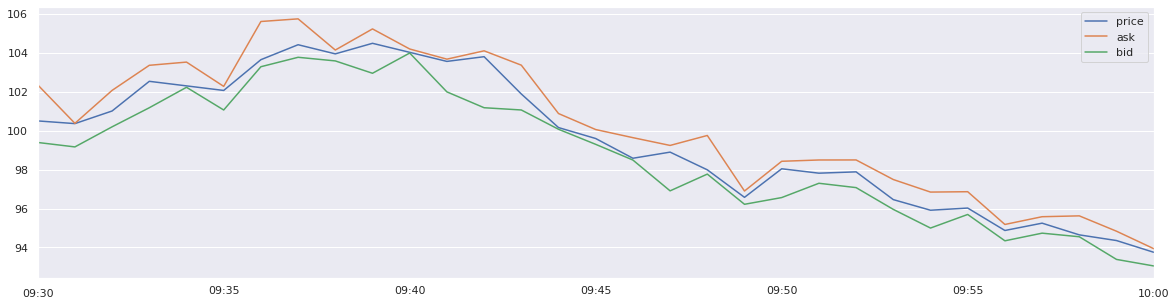

In [5]:
df.plot()

In [6]:
# Naive pnl

w0 = 100.0
w = w0
for ts, row in df_5mins[:-2].iterrows():
    _LOG.debug("ts=%s", ts)
    pred = row["preds"]
    price_5 = df.loc[ts + pd.DateOffset(minutes=5)]["price"]
    price_10 = df.loc[ts + pd.DateOffset(minutes=10)]["price"]
    _LOG.debug("# pred=%s price_5=%s price_10=%s", pred, price_5, price_10)
    # 
    num_shares = w / price_5
    if pred == 1:
        # Go long.
        buy_pnl = num_shares * price_5
        sell_pnl = num_shares * price_10
        diff = -buy_pnl + sell_pnl
    elif pred == -1:
        # Short sell.
        sell_pnl = num_shares * price_5
        buy_pnl = num_shares * price_10
        diff = sell_pnl - buy_pnl
    else:
        raise ValueError
    _LOG.debug("  w=%s num_shares=%s", w, num_shares)
    w += diff
    _LOG.debug("  diff=%s -> w=%s", diff, w)
        
print(w)
print((w - w0) / w0)

# Use lags.
df_5mins["pnl"] = df_5mins["preds"] * df_5mins["ret_0"].shift(-2)
pnls = df_5mins["pnl"][:-1]

print((1 + pnls).prod() - 1)

display(df_5mins[:-1])

ts=2021-09-08 09:30:00
# pred=-1.0 price_5=102.06087791467625 price_10=104.0171934241751
  w=100.0 num_shares=0.9798073663799055
  diff=-1.9168123471702359 -> w=98.08318765282976
ts=2021-09-08 09:35:00
# pred=-1.0 price_5=104.0171934241751 price_10=99.59294033575907
  w=98.08318765282976 num_shares=0.9429516835053714
  diff=4.1718568979757435 -> w=102.25504455080551
ts=2021-09-08 09:40:00
# pred=1.0 price_5=99.59294033575907 price_10=98.03967754008498
  w=102.25504455080551 num_shares=1.026729848582356
  diff=-1.5947812750110728 -> w=100.66026327579443
ts=2021-09-08 09:45:00
# pred=1.0 price_5=98.03967754008498 price_10=96.02322112325758
  w=100.66026327579443 num_shares=1.0267298485823557
  diff=-2.0703559915221064 -> w=98.58990728427233
ts=2021-09-08 09:50:00
# pred=-1.0 price_5=96.02322112325758 price_10=93.75388651223948
  w=98.58990728427233 num_shares=1.0267298485823557
  diff=2.3299935815533246 -> w=100.91990086582565
100.91990086582565
0.00919900865825653
0.009199008658256735


,price,ask,bid,ret_0,preds,pnl
2021-09-08 09:30:00,100.496714,102.348992,99.390379,NaN,-1.0,-0.019168
2021-09-08 09:35:00,102.060878,102.269742,101.057345,0.015564,-1.0,0.042534
2021-09-08 09:40:00,104.017193,104.188562,103.981367,0.019168,1.0,-0.015596
2021-09-08 09:45:00,99.592940,100.053579,99.293933,-0.042534,1.0,-0.020568
2021-09-08 09:50:00,98.039678,98.424760,96.561783,-0.015596,-1.0,0.023633
2021-09-08 09:55:00,96.023221,96.862439,95.694470,-0.020568,1.0,NaN


In [10]:
# Show that the previous approach (which trades two times per interval) is equivalent to trading once with the
# sum of the position.

orders = []

for ts, row in df_5mins[:-2].iterrows():
    _LOG.debug("ts=%s", ts)
    pred = row["preds"]
    if pred == 1:
        # Go long.
        action_5 = "buy"
        action_10 = "sell"
    elif pred == -1:
        # Short sell.
        action_5 = "sell"
        action_10 = "buy"
    else:
        raise ValueError
    order = (ts + pd.DateOffset(minutes=5), action_5)
    print(order)
    orders.append(order)
    order = (ts + pd.DateOffset(minutes=10), action_10)
    print(order)
    orders.append(order)
    
w0 = 100.0

def compute_pnl_from_orders(orders):
    # Assume the orders are in chronological order.
    holdings = 0.0
    cash = w0
    for order in orders:
        ts, action = order
        _LOG.debug("# ts=%s action=%s", ts, action)
        price = df.loc[ts]["price"]
        _LOG.debug("  price=%s", price)
        # 
        wealth = holdings * price + cash
        _LOG.debug("  before: cash=%s holdings=%s wealth=%s", cash, holdings, wealth)
        # Assume that we invest always all the wealth.
        num_shares = wealth / price
        if action == "buy":
            cash -= num_shares * price
            holdings += num_shares
        elif action == "sell":
            cash += num_shares * price
            holdings -= num_shares
        else:
            raise ValueError
        _LOG.debug("  after: cash=%s holdings=%s wealth=%s", cash, holdings, wealth)
    # We don't necessary liquidate the portfolio.
    return holdings * price + cash


w = compute_pnl_from_orders(orders)
print((w - w0) / w0)


ts=2021-09-08 09:30:00
(Timestamp('2021-09-08 09:35:00', freq='5T'), 'sell')
(Timestamp('2021-09-08 09:40:00', freq='5T'), 'buy')
ts=2021-09-08 09:35:00
(Timestamp('2021-09-08 09:40:00', freq='5T'), 'buy')
(Timestamp('2021-09-08 09:45:00', freq='5T'), 'sell')
ts=2021-09-08 09:40:00
(Timestamp('2021-09-08 09:45:00', freq='5T'), 'buy')
(Timestamp('2021-09-08 09:50:00', freq='5T'), 'sell')
ts=2021-09-08 09:45:00
(Timestamp('2021-09-08 09:50:00', freq='5T'), 'buy')
(Timestamp('2021-09-08 09:55:00', freq='5T'), 'sell')
ts=2021-09-08 09:50:00
(Timestamp('2021-09-08 09:55:00', freq='5T'), 'sell')
(Timestamp('2021-09-08 10:00:00', freq='5T'), 'buy')
# ts=2021-09-08 09:35:00 action=sell
  price=102.06087791467625
  before: cash=100.0 holdings=0.0 wealth=100.0
  after: cash=200.0 holdings=-0.9798073663799055 wealth=100.0
# ts=2021-09-08 09:40:00 action=buy
  price=104.0171934241751
  before: cash=200.0 holdings=-0.9798073663799055 wealth=98.08318765282976
  after: cash=101.91681234717024 holding

In [ ]:
## Case 2: interval trading, no costs

In [7]:
df_5mins = df.resample("5T", closed="right", label="right").mean()

if True:
    a = df.iloc[1:6]["price"].mean()
    b = df_5mins.iloc[1]["price"]
    #print(a, b)
    assert a == b
    
df_5mins["ret_0"] = df_5mins["price"].pct_change()

np.random.seed(42)
df_5mins["preds"] = (np.random.random(df_5mins.shape[0]) >= 0.5) * 2.0 - 1.0
display(df_5mins)

,price,ask,bid,ret_0,preds
2021-09-08 09:30:00,100.496714,102.348992,99.390379,NaN,-1.0
2021-09-08 09:35:00,101.649930,102.314622,100.761827,0.011475,1.0
2021-09-08 09:40:00,104.096694,104.975605,103.508292,0.024070,1.0
2021-09-08 09:45:00,101.794641,102.409792,100.716172,-0.022115,1.0
2021-09-08 09:50:00,98.014901,98.789490,97.188099,-0.037131,-1.0
2021-09-08 09:55:00,96.817506,97.635525,96.202972,-0.012216,-1.0
2021-09-08 10:00:00,94.575384,95.031555,94.013223,-0.023158,-1.0
